# Influence functions for Large Language Models

This notebooks showcases the use of influence functions for large language models. In particular, we will focus on sentiment analysis using the [IMDB dataset](https://ai.stanford.edu/~amaas/data/sentiment/) and a [BERT](https://arxiv.org/abs/1810.04805) model fine-tuned on it.

Not all the methods for influence function calculation can scale to large models and datasets. In this notebook we will use the [Kronecker-Factored Approximate Curvature](https://arxiv.org/abs/1503.05671) method, which is the only one that can scale to current state-of-the-art language models.

The notebook is structured as follows:
- [Setup](#Setup) imports the required libraries and download the dataset and the model.
- [Sentiment analysis](#Sentiment-analysis) loads the model and the dataset and we analyse a few examples of sentiment analysis on some sentences. This serves to understand the model and the problem we are dealing with.
- [Model and data preparation](#Model-and-data-preparation) prepares the model and the dataset for the influence function calculation. In particular, here we assign all the linear layers to require gradients and wrap the model to return only the logits (and not the loss or attention masks).
- [Influence function computation](#Influence-function-computation): shows how to calculate the influence function for a few test and train examples.
- [Analysis of influence values](#Analysis-of-influence-values): here we analyse the influence values to understand how the model works and how it is affected by corruption in the training data. Here we also corrupt some of the training examples to see how the influence function changes.
- [Influence functions by layer](#Influence-functions-by-layer): since ekfac is based on a block diagonal approximation of the Fisher information matrix, we can compute the influence function separately for each layer of the neural network. In this section we show how to do that and how to analyse the results.

Finally, in the [Appendix](#Appendix) we show how to select the Hessian regularization parameter to obtain the best possible influence function approximation.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate has been omitted for convenience.

</div>

## Setup

In [1]:
%load_ext autoreload

Let's start by importing the required libraries. If not already installed, you can install them with `pip install -r requirements-notebooks.txt`.

In [2]:
from datasets import load_dataset
import torch
from sklearn.metrics import f1_score
from typing import Sequence
from pydvl.influence.torch import EkfacInfluence
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from copy import deepcopy
from IPython.display import HTML, display
import matplotlib.pyplot as plt

/Users/fabio/miniconda3/envs/pydvl_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Sentiment Analysis

Sentiment analysis is the task of classifying a sentence as having a positive or negative sentiment. For example, the sentence "I love this movie" has a positive sentiment, while "I hate this movie" has a negative sentiment. In this notebook we will use the IMDB dataset, which contains 50,000 movie reviews, each labelled as positive or negative. The dataset is split into 25,000 reviews for training and 25,000 reviews for testing. The dataset is balanced, meaning that there are the same number of positive and negative reviews in the training and test set.

In [5]:
imdb = load_dataset("imdb")

Found cached dataset imdb (/Users/fabio/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 310.53it/s]


Let's print an example of review and its label

In [6]:
sample_review = imdb["train"].select([24])

print(f"Here is a sample review with label {sample_review['label'][0]}: \n")

display(HTML(sample_review["text"][0].split("<br />")[0]))
display(HTML(sample_review["text"][0].split("<br />")[-1]))

Here is a sample review with label 0: 



The review is negative, and so label 0 is associated to negative sentiment.

The model we will use is a BERT model fine-tuned on the IMDB dataset. BERT is a large language model that has been pre-trained on a large corpus of text. The model was fine-tuned on the IMDB dataset using by AssemblyAI and is available on the HuggingFace model hub. We will also load its tokenizer, which is used to convert sentences into tokens that can be fed to the model.

In [7]:
tokenizer = AutoTokenizer.from_pretrained("assemblyai/distilbert-base-uncased-sst2")
model = AutoModelForSequenceClassification.from_pretrained(
    "assemblyai/distilbert-base-uncased-sst2"
)

Even if the model is trained on movie reviews, it can be used to classify any sentence as positive or negative. Let's try it on a simple example created by us.

In [8]:
example_phrase = (
    "Pydvl is the best data valuation library, and it is fully open-source!"
)

tokenized_example = tokenizer(
    [example_phrase],
    return_tensors="pt",
    padding=True,
    truncation=True,
)

tokenized_example_input_ids, tokenized_example_attention_mask = (
    tokenized_example.input_ids,
    tokenized_example.attention_mask,
)

model_output = model(
    input_ids=tokenized_example_input_ids,
    attention_mask=tokenized_example_attention_mask,
)

The model output is a `SequenceClassificationOutput` object, which contains the logits and other information.

In [9]:
print("Model Output:\n", model_output)

Model Output:
 SequenceClassifierOutput(loss=None, logits=tensor([[-2.6237,  2.8350]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


For calculating probabilities, and for the influence function calculation, we only need the logits. We then use the softmax function to convert the logits into probabilities.

In [10]:
model_predictions = F.softmax(
    model(
        input_ids=tokenized_example_input_ids,
        attention_mask=tokenized_example_attention_mask,
    )["logits"],
    dim=1,
)

model_predictions thus contains the probabilities for each class. In this case, the model is quite confident that the sentence has a positive sentiment, which is correct.

In [11]:
print(
    "Positive probability: " + str(round(model_predictions[0][1].item(), 3) * 100) + "%"
)
print(
    "Negative probability: " + str(round(model_predictions[0][0].item(), 3) * 100) + "%"
)

Positive probability: 99.6%
Negative probability: 0.4%


Let's examine the model's f1 score on a small subset of the test set.

In [12]:
sample_test_set = imdb["test"].shuffle(seed=seed).select(range(50))
sample_test_set = sample_test_set.map(
    lambda example: tokenizer(example["text"], truncation=True, padding="max_length"),
    batched=True,
)
sample_test_set.set_format("torch", columns=["input_ids", "attention_mask", "label"])
model.eval()
with torch.no_grad():
    logits = model(
        input_ids=sample_test_set["input_ids"],
        attention_mask=sample_test_set["attention_mask"],
    )[0]
    predictions = torch.argmax(logits, dim=1)

Loading cached shuffled indices for dataset at /Users/fabio/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-c1eaa46e94dfbfd3.arrow
Loading cached processed dataset at /Users/fabio/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-c5cc0d728c27151c.arrow


In [13]:
f1_score_value = f1_score(sample_test_set["label"], predictions)
print(f"F1 Score: {round(f1_score_value, 3)}")

F1 Score: 0.955


F1 score is quite good, but not perfect. Anyway, it is good enough for our purposes.

## Model and Data Preparation

In this section we will define several helper function and classes that will be used in the rest of the notebook. 

In [14]:
class ImdbDataset(torch.utils.data.Dataset):
    """
    A PyTorch Dataset that takes in an HuggingFace Dataset object and tokenizes it.
    The objects returned by __getitem__ are PyTorch tensors, with x being a tuple of
    (input_ids, attention_mask), ready to be fed into a model, and y being the label.
    It also returns the original text, for printing and debugging purposes.
    """

    def __init__(self, dataset):
        self.tokenized_ds = dataset.map(self.preprocess_function, batched=True)
        self.encodings = self.tokenized_ds["input_ids"]
        self.attn_mask = self.tokenized_ds["attention_mask"]
        self.labels = self.tokenized_ds["label"]

    def preprocess_function(self, examples):
        return tokenizer(examples["text"], truncation=True, padding=True)

    def __getitem__(self, idx):
        x = torch.tensor([self.encodings[idx], self.attn_mask[idx]])
        y = torch.tensor(self.labels[idx])
        text = self.tokenized_ds[idx]["text"]
        return x, y, text

    def __len__(self):
        return len(self.labels)


class ModelLogitsWrapper(torch.nn.Module):
    """
    A wrapper around a PyTorch model that returns only the logits and not the loss or
    the attention mask.
    """

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x[:, 0], x[:, 1])["logits"]


def print_sentiment_preds(
    model: ModelLogitsWrapper, model_input: torch.Tensor, true_label: int
):
    """
    Prints the sentiment predictions in a human-readable format given a model and an
    input. It also prints the true label.
    """
    model_predictions = F.softmax(model(model_input.unsqueeze(0)), dim=1)
    print(
        "Positive probability: "
        + str(round(model_predictions[0][1].item(), 3) * 100)
        + "%"
    )
    print(
        "Negative probability: "
        + str(round(model_predictions[0][0].item(), 3) * 100)
        + "%"
    )

    true_label = "Positive" if true_label == 1 else "Negative"
    print(f"True label: {true_label} \n")


def strip_layer_names(param_names: Sequence[str]):
    """
    Helper function that strips the parameter names of the model and the transformer,
    so that they can be printed and compared more easily.
    """
    stripped_param_names = []
    for name in param_names:
        name = name.replace("model.", "")
        if name.startswith("distilbert.transformer."):
            name = name.replace("distilbert.transformer.", "")
        stripped_param_names.append(name)
    return stripped_param_names

Importantly, we will need to assign all the linear layers to require gradients, so that we can compute the influence function with respect to them. Keep in mind that the current implementation of Ekfac only supports linear layers, so if any other type of layer in the model requires gradients, the influence function calculation will return a `NotImplementedError`.

In [15]:
for param in model.named_parameters():
    param[1].requires_grad = False

for m_name, module in model.named_modules():
    if len(list(module.children())) == 0 and len(list(module.parameters())) > 0:
        if isinstance(module, torch.nn.Linear):
            for p_name, param in module.named_parameters():
                if (
                    "ffn" in m_name
                    or "pre_classifier" in m_name
                    or "classifier" in m_name
                ):
                    param.requires_grad = True

Nevertheless, linear layers constitute a large fraction of the parameters of the model, so our analysis still holds a lot of information about the full model.

In [16]:
total_params = sum(p.numel() for p in model.parameters()) / 1e6
params_requiring_grad = (
    sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
)

print("Total parameters: {:.2f} millions".format(total_params))
print("Parameters requiring gradients: {:.2f} millions".format(params_requiring_grad))
print(
    "Ratio of Linear over other layer types: {:.2f}%".format(
        (params_requiring_grad / total_params) * 100
    )
)

Total parameters: 66.96 millions
Parameters requiring gradients: 28.93 millions
Ratio of Linear over other layer types: 43.20%


## Influence function computation

We are now ready to compute the influence function for a few test and train examples. Let's start by selecting a subset of the full training and testing dataset and wrapping them in a `DataLoader` object, so that we can easily batch the examples.

In [17]:
NUM_TRAIN_EXAMPLES = 100
NUM_TEST_EXAMPLES = 100

small_train_dataset = (
    imdb["train"]
    .shuffle(seed=seed)
    .select([i for i in list(range(NUM_TRAIN_EXAMPLES))])
)
small_test_dataset = (
    imdb["test"].shuffle(seed=seed).select([i for i in list(range(NUM_TEST_EXAMPLES))])
)

train_dataset = ImdbDataset(small_train_dataset)
test_dataset = ImdbDataset(small_test_dataset)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=7, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=True)

Loading cached shuffled indices for dataset at /Users/fabio/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-9c48ce5d173413c7.arrow
Loading cached shuffled indices for dataset at /Users/fabio/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-c1eaa46e94dfbfd3.arrow
Loading cached processed dataset at /Users/fabio/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-9aaaa3770ef3f9bf.arrow
Loading cached processed dataset at /Users/fabio/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-7a8cbae367cafa72.arrow


For influence computation, we will need to take the model in evaluation mode, so that no dropout or batch normalization is applied. Then, we can fit the Ekfac representation.

In [18]:
wrapped_model = ModelLogitsWrapper(model)
wrapped_model.eval()

ekfac_influence_model = EkfacInfluence(
    wrapped_model,
    progress=True,
)
ekfac_influence_model = ekfac_influence_model.fit(train_dataloader)

K-FAC blocks - batch progress:   0%|          | 0/15 [00:00<?, ?it/s]

K-FAC blocks - batch progress: 100%|██████████| 15/15 [01:49<00:00,  7.28s/it]


And the approximate Hessian is thus obtained. Considering that the model has almost 30 million parameters requiring gradients, this was very fast! Of course, we should keep in mind that this Hessian is computed using only a very small fraction (~0.4%) of the training data, and for a better approximation we should use a larger subset.

Before continuing, we need to set the Hessian regularization parameter to an appropriate value. A way to decide which value is better can be found in the [Appendix](#Appendix). Here, we will just set it to 1e-5.

In [19]:
ekfac_influence_model.hessian_regularization = 1e-5

We will calculate the influence of the first batch of training data over the first batch of test data. This because influence functions are very expensive to compute, and to keep the computation time reasonable we will only compute the influence of a few examples.

In [20]:
test_input, test_labels, test_text = next(iter(test_dataloader))
train_input, train_labels, train_text = next(iter(train_dataloader))

And let's finally compute the influence function values

In [21]:
ekfac_train_influences = ekfac_influence_model.influences(
    test_input,
    test_labels,
    train_input,
    train_labels,
)

/Users/fabio/miniconda3/envs/pydvl_env/lib/python3.9/site-packages/transformers/models/distilbert/modeling_distilbert.py:222: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::masked_fill.Tensor. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  scores = scores.masked_fill(


## Analysis of influence values

Now that we have calculated the influences for a few examples, let's analyse some of the extreme values to hopefully understand how the model works and how it is affected by corruption in the training data.

### Negative influence training examples

Let's plot the influence values as a heatmat to see if there are any patterns.

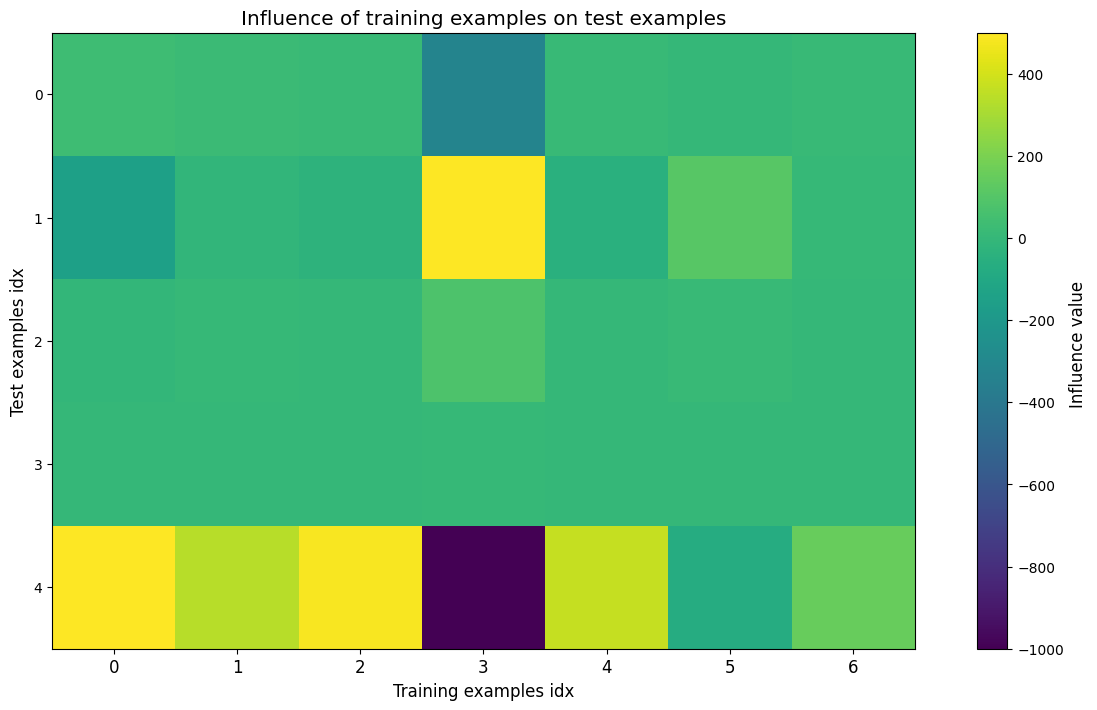

In [22]:
plt.imshow(ekfac_train_influences.numpy().astype(int), vmin=-1000, vmax=500)
plt.colorbar(label="Influence value ")
plt.title("Influence of training examples on test examples")
plt.xlabel("Training examples idx")
plt.ylabel("Test examples idx")
plt.show()

Most of the test and training examples have similar influence, close to zero. However, there is one test and one training example that stand out. In particular, their influence is a very large negative values. Let's see what these examples are.

In [23]:
train_sentence_idx = 3

print(f"Training example with idx {train_sentence_idx}: \n")

print_sentiment_preds(
    wrapped_model,
    train_input[train_sentence_idx],
    train_labels[train_sentence_idx].item(),
)

print("Sentence:")
display(HTML(train_text[train_sentence_idx]))

Training example with idx 3: 

Positive probability: 18.099999999999998%
Negative probability: 81.89999999999999%
True label: Positive 

Sentence:


We can see that, despite being positive, this review is quite hard to classify. Its language is overall negative, mostly related to the facts narrated rather than the movie itself. Notice also how several terms are related to war and invasion.

In [24]:
test_sentence_idx = 4

print(f"Test example with idx {test_sentence_idx}: \n")

print_sentiment_preds(
    wrapped_model, test_input[test_sentence_idx], test_labels[test_sentence_idx].item()
)

print("Sentence:")
display(HTML(test_text[test_sentence_idx]))

Test example with idx 4: 

Positive probability: 39.6%
Negative probability: 60.4%
True label: Negative 

Sentence:


This review is also quite hard to classify. This time it is negative, but it contains several positive terms. The parallel with the previous review is quite interesting, since both reviews talk about an invasion. 

As it is often the case when analysing influence functions, it is hard to understand why these examples have such a large influence. We have seen some interesting patterns, mostly related to similarities in the language and words used, but it is hard to say with certainty if these are the reasons for the large influence.

A [recent paper](https://arxiv.org/abs/2308.03296) has explored these patterns in high detail, even for much larger language models than bert (up to ~50 billion parameters!). What has been found is that while smaller models tend to rely a lot on word-to-word correspondencies, larger models are more capable to extract higher level concepts, drawing connections between words from the whole sentence.
For more info, you can visit our [blog on influence functions for large language models](https://transferlab.ai/pills/2023/llm-influences-with-ekfac/)

### Influence of corrupted training examples

The limited computational resources available to us do not allow us to compute the influence function for all the training examples. However, we can still get an idea of how the influence function changes when we corrupt the training examples. In the next cell we will flip the label of all the training examples and compute the influence function for the same test examples as before.

In [25]:
modified_train_labels = deepcopy(train_labels)
modified_train_labels = 1 - train_labels

corrupted_ekfac_train_influences = ekfac_influence_model.influences(
    test_input,
    test_labels,
    train_input,
    modified_train_labels,
)

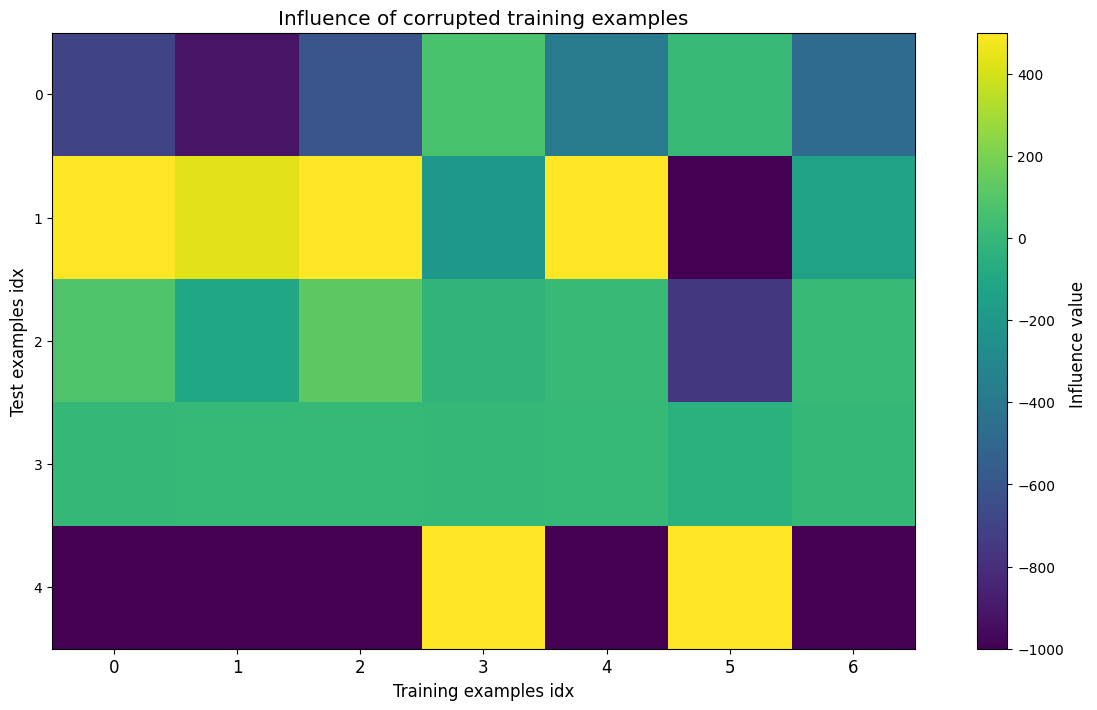

In [26]:
plt.imshow(corrupted_ekfac_train_influences.numpy().astype(int), vmin=-1000, vmax=500)
plt.colorbar(label="Influence value ")
plt.title("Influence of corrupted training examples")
plt.xlabel("Training examples idx")
plt.ylabel("Test examples idx")
plt.show()

Overall, when corrupted the influences turn from positive to negative and vice versa, as expected. More interestingly, some influences that were close to zero before corruption now have a large magnitude, while others keep having a small magnitude.

## Influence functions by layer

Since ekfac is based on a block diagonal approximation of the Fisher information matrix, we can compute the influence function separately for each layer of the neural network. In this section we show how to do that and we briefly analyse the results.

In [27]:
influences_by_layer = ekfac_influence_model.influences_by_layer(
    test_input,
    test_labels,
    train_input,
    train_labels,
)

The method `influences_by_layer` returns a dictionary containing the influence function values for each layer of the neural network as a tensor. To recover the full influence values as returned by `influences`, we need can sum the values in the dictionary as follows.

In [28]:
influences = torch.zeros_like(ekfac_train_influences)
for layer_id, value in influences_by_layer.items():
    influences += value.detach()

And if we plot the influence values as a heatmap, as done in section [Negative influence training examples](#Negative-influence-training-examples), we can see that the results are the same.

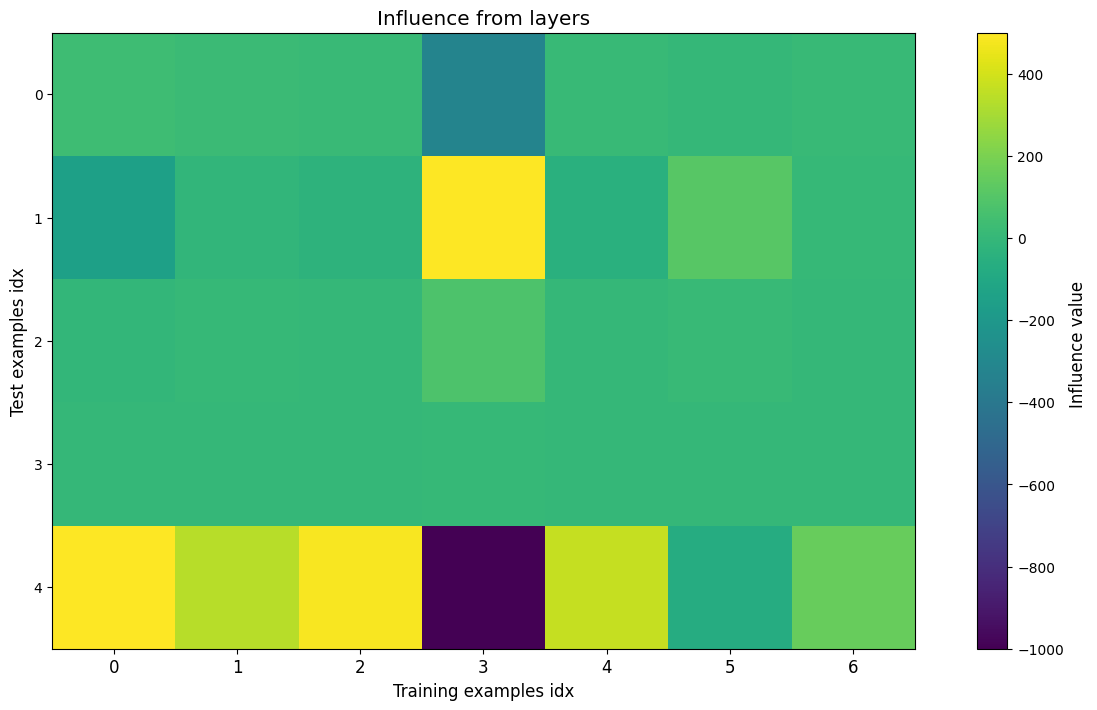

In [29]:
plt.imshow(influences.numpy().astype(int), vmin=-1000, vmax=500)
plt.colorbar(label="Influence value ")
plt.title("Influence from layers")
plt.xlabel("Training examples idx")
plt.ylabel("Test examples idx")
plt.show()

Let's analyse how the influence values change across different layers for given test and train examples. 

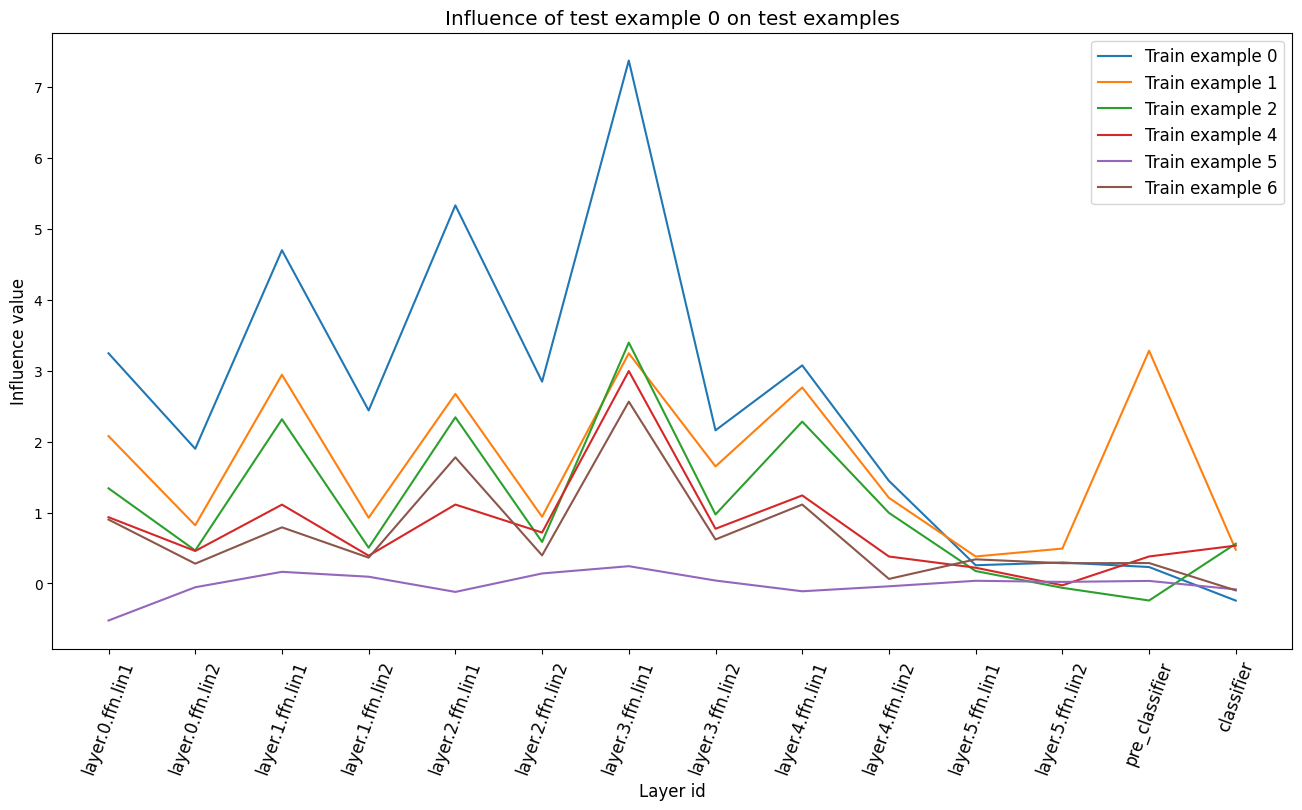

In [30]:
test_idx = 0

train_idx_to_plot = list(range(len(ekfac_train_influences[0])))
train_idx_to_plot.pop(3)
for train_idx in train_idx_to_plot:
    infl_across_layers = []
    idx = (test_idx, train_idx)
    for layer_id, value in influences_by_layer.items():
        infl_across_layers.append(value[idx].item())
    plt.plot(infl_across_layers, label=f"Train example {train_idx}")
plt.legend()
plt.xticks(
    range(len(influences_by_layer.keys())),
    strip_layer_names(influences_by_layer.keys()),
    rotation=70,
)
plt.xlabel("Layer id")
plt.ylabel("Influence value")
plt.title(f"Influence of test example {test_idx} on test examples")
plt.show()

The plot above shows the influences for test idx 0 and all train idx apart idx=3 (excluded for clarity since it has a very large influence). We can see that the influence values keep their sign across layers, but in almost all casesthey tend to decrease when approaching the output layer. This is not always the case, and in fact other test examples show different patterns. Understanding why this happens is an interesting research direction.

## Conclusion

Ekfac is a powerful approximate method for computing the influence function of models that use a cross-entropy loss. In this notebook we have shown how to use it for a sentiment analysis with BERT on the IMDB dataset. However, this method can be applied to much larger models and problems, e.g. to analyse the influence of entire sentences generated by GPT, Llama or Claude. For more info, you can visit our [blog on influence functions for large language models](https://transferlab.ai/pills/2023/llm-influences-with-ekfac/)

## Appendix: Choosing the Hessian regularization value

The Hessian regularization value impacts a lot the quality of the influence function approximation. In general, the value should be chosen as small as possible so that the influence values are finite. However, even when finite the influence values can be very large, which can lead to numerical instabilities. In this section we show how to efficiently analyse the impact of the Hessian regularization value in the ekfac representation. 

Let's start with a few additional imports.

In [31]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

The method `explore_hessian_regularization` will calculate the influence values of the training examples with each other for a range of Hessian regularization values. The method optimises gradient calculation and Hessian inversion to minimise the computation time.

In [32]:
influences_by_reg_value = ekfac_influence_model.explore_hessian_regularization(
    train_input,
    train_labels,
    regularization_values=[1e-15, 1e-9, 1e-5, 1],
)

The resulting object, `influences_by_reg_value` is a dictionary that associates to each regularization value the influences for each layer of the neural network. This is a lot of data, so we will first organise it in a pandas dataframe and take the average across training examples.

In [33]:
cols = ["reg_value", "layer_id", "mean_infl"]
infl_df = pd.DataFrame(influences_by_reg_value, columns=cols)
for reg_value in influences_by_reg_value:
    for layer_id, layer_influences in influences_by_reg_value[reg_value].items():
        mean_infl = torch.mean(layer_influences, dim=0).detach().numpy()
        infl_df = pd.concat(
            [infl_df, pd.DataFrame([[reg_value, layer_id, mean_infl]], columns=cols)]
        )

With this dataframe, we can take contiguous values of the regularization regularizationa and, for each layer, calculate the Pearson and Spearman correlation coefficients across training examples. This will give us an idea of how the influence values change when the regularization value changes.

In [34]:
result_corr = {}
for layer_id, group_df in infl_df.groupby("layer_id"):
    result_corr[layer_id + "_pearson"] = {}
    result_corr[layer_id + "_spearman"] = {}
    for idx, mean_infl in enumerate(group_df["mean_infl"]):
        if idx == 0:
            continue
        reg_value_diff = f"Reg: {group_df['reg_value'].iloc[idx-1]} -> {group_df['reg_value'].iloc[idx]}"
        pearson = pearsonr(mean_infl, group_df["mean_infl"].iloc[idx - 1]).statistic
        spearman = spearmanr(mean_infl, group_df["mean_infl"].iloc[idx - 1]).statistic
        result_corr[layer_id + "_pearson"].update({f"{reg_value_diff}": pearson})
        result_corr[layer_id + "_spearman"].update({f"{reg_value_diff}": spearman})
result_df = pd.DataFrame(result_corr).T

Let's plot the correlations heatmap. The y-axis reports Spearman and Pearson correlations for each layer, while the x-axis reports pairs of regularization values. High correlations mean that the influence values are stable across regularization values. 

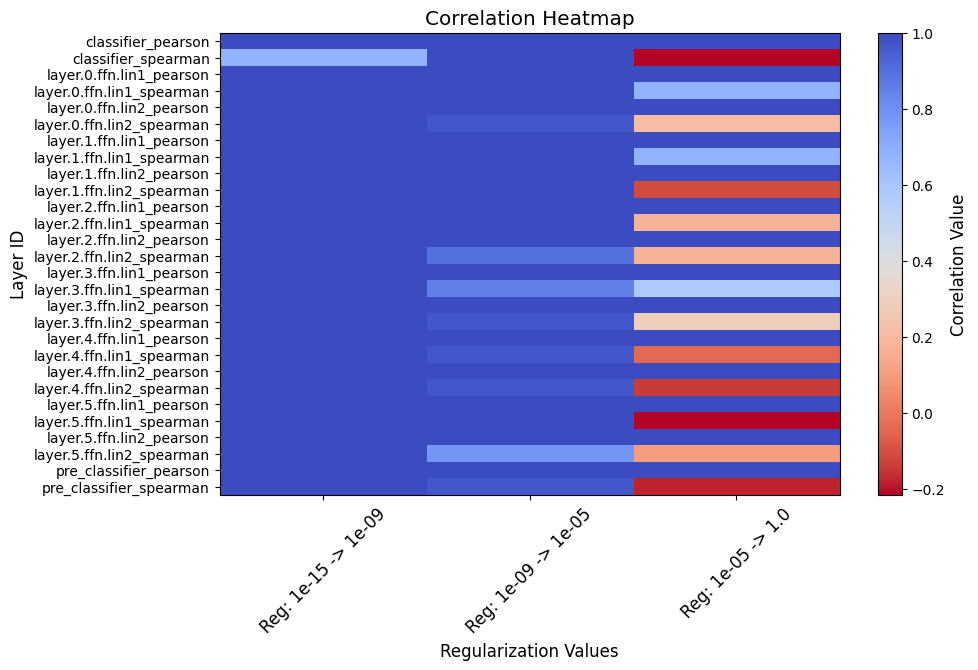

In [35]:
plt.figure(figsize=(10, 6))
plt.imshow(result_df, cmap="coolwarm_r", aspect="auto")
plt.xticks(range(result_df.shape[1]), result_df.columns, rotation=45)
plt.yticks(range(result_df.shape[0]), strip_layer_names(result_df.index))
plt.colorbar(label="Correlation Value")
plt.title("Correlation Heatmap")
plt.xlabel("Regularization Values")
plt.ylabel("Layer ID")
plt.show()

In our case, we can see that for regularization equals to 1 the correlations become very bad. However, for a large range of parameters before that the influences rankings are very stable. This is a good indication that the model is not too sensitive to the regularization value. We therefore choose 1e-5 as the regularization value for the rest of the notebook.